In [6]:
import os
from rank_bm25 import BM25Okapi
import pandas as pd
import numpy as np
import random
import sys
import csv
import string
csv.field_size_limit(sys.maxsize)

131072

### Query 

Формируем словарик query_to_id со всеми запросами, назначаем им id, с помощью которого мы далее составим привычные нам таблицы query, docs, qrels

### Function for parsing of full docs and queries files 

In [2]:
def write_queries_file(dataset_file_path, dataset_filename, return_dicts=True):
    query_to_id = {}
    query_id = 0
    id_q = 0 
    with open(os.path.join(dataset_file_path, dataset_filename), 'r') as f:
        csv_reader = csv.reader(f, delimiter='\t')
        for line in csv_reader:
            
            # QUERIES CHECK
            if len(line) == 7:
                label, query, _, _, _, data, _ = line 
                if query in query_to_id:
                    continue # запрос не уникален, пропускаем
                else:
                    query_to_id[query] = query_id # нам еще не попадался такой запрос
                    query = query.translate(str.maketrans('', '', string.punctuation)).lower()
                    with open(os.path.join(dataset_file_path, 'queries.tsv'), 'a', newline='') as new_file:
                        writer = csv.writer(new_file, delimiter='\t', lineterminator='\n')
                        writer.writerow([id_q, query_id, query])
                    id_q += 1
                    query_id += 1

    print('Unique queries found:', len(query_to_id.values()))
    if return_dicts:
        # Возвращаю дикты всех запросов, так как они будет использоваться дальше
        return query_to_id 

In [3]:
query_to_id = write_queries_file('/home/tatiana/MADE/Project/VK_Dataset',
                                                 'assessors_train_l_q_u_t_m_b_ql.tsv', 
                                                 return_dicts = True)

Unique queries found: 54511


In [4]:
len(query_to_id.values()), max(query_to_id.values())

(54511, 54510)

### Docs, Qrels

Формируем словарик со всеми документами doc_to_id, чтобы назначить им айди документа

In [5]:
import os

def write_docs_file(dataset_file_path, dataset_filename, query_to_id, return_dicts=True):
    doc_to_id = {}
    doc_num = 0
    doc_str = 'D'
    id_d = -1
    id = 0
    with open(os.path.join(dataset_file_path, dataset_filename), 'r') as f:
        csv_reader = csv.reader(f, delimiter='\t')
        for line in csv_reader:
            id_d += 1
            doc_id = doc_str + str(doc_num)
            if len(line) == 7:
                label, query, _, _, _, data, _ = line 
                data = data.translate(str.maketrans('', '', string.punctuation)).lower()
                data_short = ' '.join(data.lower().split()[:400])
                if data_short in doc_to_id:
                    continue
                else:
                    doc_to_id[data_short] = doc_id
                    with open(os.path.join(dataset_file_path,'docs.tsv'), 'a', newline='') as new_file:
                        writer = csv.writer(new_file, delimiter='\t', lineterminator='\n')
                        writer.writerow([id_d, doc_id, data])
                    doc_num += 1
                
                if label in ('3'):
                    query_id = query_to_id[query]
                    doc_id = doc_to_id[data_short]
                    with open(os.path.join(dataset_file_path, 'qrels.tsv'), 'a', newline='') as new_file:
                        writer = csv.writer(new_file, delimiter='\t', lineterminator='\n')
                        writer.writerow([id, query_id, doc_id])
                    id += 1          
            
    print('Unique docs found:', len(set(doc_to_id.values())))
    print('Qrels number written:', id)
    if return_dicts:
        # Возвращаю дикты всех документов, так как они будет использоваться дальше
        return doc_to_id

In [ ]:
doc_to_id = write_docs_file('/home/tatiana/MADE/Project/VK_Dataset',
                            'assessors_train_l_q_u_t_m_b_ql.tsv', 
                            query_to_id,
                            return_dicts = True)

In [ ]:
len(doc_to_id.values()), len(set(doc_to_id.values()))

In [19]:
len(doc_to_id.values()), len(set(doc_to_id.values()))

(1304200, 1304200)

### Формируем dev выборку из датасета - попробуем захватить как можно больше уникальных query

In [8]:

def dev_qrels_write(qrels_file_path, qrels_filename, dev_size):
    dev_docs_selected = set()
    dev_queries_selected = set()
    sampled_qrels_id = random.sample(range(0, 190000), dev_size + 2000)
    with open(os.path.join(qrels_file_path, qrels_filename), 'r') as f:
        csv_reader = csv.reader(f, delimiter='\t')
        for line in csv_reader:
            id, query_id, doc_id = line
            if query_id not in dev_queries_selected and int(id) in sampled_qrels_id:
                dev_queries_selected.add(query_id)
                dev_docs_selected.add(doc_id)
                with open(os.path.join(qrels_file_path, 'dev_qrels.tsv'), 'a', newline='') as new_file:
                    writer = csv.writer(new_file, delimiter='\t', lineterminator='\n')
                    writer.writerow([id, query_id, doc_id])
            if len(dev_queries_selected) >= dev_size:
                      break
    print(len(dev_queries_selected), 'qrels selected and written to dev_qrels.tsv')
    print(len(dev_docs_selected), 'docs selected')
    return dev_queries_selected, dev_docs_selected

dev_queries_selected, dev_docs_selected = dev_qrels_write('/home/tatiana/MADE/Project/VK_Dataset', 'qrels.tsv', 15000)

10886 qrels selected and written to dev_qrels.tsv
10886 docs selected


In [10]:
def dev_docs_write(docs_file_path, docs_filename, dev_docs_selected):
    with open(os.path.join(docs_file_path, docs_filename), 'r') as f:
        csv_reader = csv.reader(f, delimiter='\t')
        for line in csv_reader:
            id_d, doc_id, data = line 
            if doc_id in dev_docs_selected:
                with open(os.path.join(docs_file_path, 'dev_docs.tsv'), 'a', newline='') as new_file:
                    writer = csv.writer(new_file, delimiter='\t', lineterminator='\n')
                    writer.writerow([id_d, doc_id, data])
    
dev_docs_write('/home/tatiana/MADE/Project/VK_Dataset', 'docs.tsv', dev_docs_selected)

In [11]:
def dev_queries_write(queries_file_path, queries_filename, dev_queries_selected):
    with open(os.path.join(queries_file_path, queries_filename), 'r') as f:
        csv_reader = csv.reader(f, delimiter='\t')
        for line in csv_reader:
            id_q, query_id, query = line 
            if query_id in dev_queries_selected:
                with open(os.path.join(queries_file_path, 'dev_queries.tsv'), 'a', newline='') as new_file:
                    writer = csv.writer(new_file, delimiter='\t', lineterminator='\n')
                    writer.writerow([id_q, query_id, query])
    
dev_queries_write('/home/tatiana/MADE/Project/VK_Dataset', 'queries.tsv', dev_queries_selected)

Сопоставляем словари документов и запросов, чтобы записать нужные нам файлы docs, qrels

### Try opening dev data

In [77]:
import pandas as pd
df = pd.read_csv('dev_docs/qrels.tsv', names=['id', 'query_id', 'doc_id'],  sep='\t')
docs_df = pd.read_csv('dev_docs/docs.tsv', names=['id', 'doc_id', 'data'],  sep='\t')
queries = pd.read_csv('dev_docs/queries.tsv', names=['id', 'query_id', 'data'],  sep='\t')
# queries = queries[['query_id', 'data']]

In [78]:
def create_joined_file(df_docs, df_qrels, df_queries, path_processed_joined=None):
    joined_df = df_qrels.merge(df_queries, on='query_id').merge(df_docs, on='doc_id', how='left')[['query_id', 'data_x', 'doc_id', 'data_y']]
    joined_df.rename(columns={'data_x':'query_data', 'data_y':'doc_data'}, inplace=True)
    if path_processed_joined:
        joined_df.to_csv(path_processed_joined, sep='\t', index=None, header=None)
    return joined_df

joined_df = create_joined_file(docs_df, df, queries)

In [96]:
len(doc_to_id.keys()), len(query_to_id.values())

NameError: name 'doc_to_id' is not defined

### Dataset look up 

In [2]:
import pandas as pd
df = pd.read_csv('train_qrels.tsv', names=['id', 'query_id', 'doc_id'],  sep='\t')
docs_df = pd.read_csv('train_docs.tsv', names=['id', 'doc_id', 'data'],  sep='\t')
queries = pd.read_csv('train_queries.tsv', names=['id', 'query_id', 'data'],  sep='\t')
queries = queries[['query_id', 'data']]

In [7]:
def create_joined_file(df_docs, df_qrels, df_queries, path_processed_joined=None):
    joined_df = df_qrels.merge(df_queries, on='query_id').merge(df_docs, on='doc_id', how='left')[['query_id', 'data_x', 'doc_id', 'data_y']]
    joined_df.rename(columns={'data_x':'query_data', 'data_y':'doc_data'}, inplace=True)
    if path_processed_joined:
        joined_df.to_csv(path_processed_joined, sep='\t', index=None, header=None)
    return joined_df

joined_df = create_joined_file(docs_df, df, queries)

In [13]:
joined_df.query_id.nunique(), len(joined_df), joined_df.doc_id.nunique()

(5200, 5200, 5200)

In [1]:
import os
from rank_bm25 import BM25Okapi
import pandas as pd
import numpy as np

corpus = list(joined_df['doc_data'].values)
tokenized_corpus = [corp.split(" ") for corp in corpus]

bm25 = BM25Okapi(tokenized_corpus)

def predicting_100_top_doc_id(joined_df, bm25):
    predict_on_query = []
    predicted_scores = []
    for query_id, query in zip(list(joined_df['query_id']), list(joined_df['query_data'])):
        query = query.split()
        score = bm25.get_scores(query)
        top_100_scores = np.round(score[score >= pd.Series(score).nlargest(100).values[-1]], 1)# score[score >= pd.Series(score).nlargest(100).values[-1]]
        top_100_doc_id = joined_df['doc_id'][score >= pd.Series(score).nlargest(100).values[-1]].values
        score_dicts = [{doc:score} for (doc, score) in zip(top_100_doc_id, top_100_scores)]
        predict_on_query.append(list(top_100_doc_id))
        predicted_scores.append(list(top_100_scores))
    return predict_on_query, predicted_scores

joined_df['predict_100'], joined_df['predict_100_score'] = predicting_100_top_doc_id(joined_df, bm25)

NameError: name 'joined_df' is not defined

### BM 25 Just docs

In [8]:
from rank_eval import Qrels, Run, evaluate
qrels = Qrels()
qrels.add_multi(q_ids=[str(i) for i in list(joined_df['query_id'].values)], 
                doc_ids=[[i] for i in joined_df['doc_id']],
                scores=[[1.0] for i in range(len(joined_df))])

run = Run()
run.add_multi(q_ids=[str(i) for i in list(joined_df['query_id'].values)], 
                doc_ids=[i for i in joined_df['predict_100']],
                scores=[i for i in joined_df['predict_100_score']])

evaluate(qrels, run, ["mrr@100"])

0.7173371945450365

In [2]:
joined_df['old_doc_data'] = joined_df['doc_data']
joined_df['doc_data'] = joined_df['query_data'] + ' ' + joined_df['doc_data']

NameError: name 'joined_df' is not defined

### BM 25 Ideal docs

In [18]:
corpus = list(joined_df['doc_data'].values)
tokenized_corpus = [corp.split(" ") for corp in corpus]

bm25 = BM25Okapi(tokenized_corpus)

In [3]:
# predict 100 docs on the added queries and docs
joined_df['predict_100'], joined_df['predict_100_score'] = predicting_100_top_doc_id(joined_df, bm25)

NameError: name 'predicting_100_top_doc_id' is not defined

In [20]:
from rank_eval import Qrels, Run, evaluate
qrels = Qrels()
qrels.add_multi(q_ids=[str(i) for i in list(joined_df['query_id'].values)], 
                doc_ids=[[i] for i in joined_df['doc_id']],
                scores=[[1.0] for i in range(len(joined_df))])

run = Run()
run.add_multi(q_ids=[str(i) for i in list(joined_df['query_id'].values)], 
                doc_ids=[i for i in joined_df['predict_100']],
                scores=[i for i in joined_df['predict_100_score']]) # [[1.0] * 100 for i in range(len(joined_df))])

In [21]:
evaluate(qrels, run, ["mrr@100"])

0.9777399624204771

### Let's look at some statistics

In [3]:
vk = 'dev_docs/'
ms = '../msmarco_data/'

import pandas as pd
vk_qrels = pd.read_csv(vk + 'qrels.tsv', names=['id', 'query_id', 'doc_id'],  sep='\t')
vk_docs = pd.read_csv(vk + 'docs.tsv', names=['id', 'doc_id', 'data'],  sep='\t')
vk_queries = pd.read_csv(vk + 'queries.tsv', names=['id', 'query_id', 'data'],  sep='\t')

ms_qrels = pd.read_csv(ms + 'qrels.tsv', names=['id', 'query_id', 'doc_id'],  sep='\t')
ms_docs = pd.read_csv(ms + 'docs.tsv', names=['id', 'doc_id', 'data'],  sep='\t')
ms_queries = pd.read_csv(ms + 'queries.tsv', names=['id', 'query_id', 'data'],  sep='\t')

In [86]:
vk_docs['id'] = list(range(len(vk_docs)))
vk_qrels['id'] = list(range(len(vk_qrels)))
vk_queries['id'] = list(range(len(vk_queries)))

vk_docs[['id', 'doc_id', 'data']].to_csv('docs.tsv', index=False,header=None, sep='\t', encoding='utf-8')
vk_qrels.to_csv('qrels.tsv', index=False, sep='\t', header=None, encoding='utf-8')
vk_queries[['id', 'query_id', 'data']].to_csv('queries.tsv', index=False, header=None, sep='\t',  encoding='utf-8')

In [2]:
# pd.set_option('display.max_colwidth', 150)
# #pd.set_option('display.expand_frame_repr', False)
# pd.DataFrame(vk_docs.data[5:15])

In [1]:
# pd.set_option('display.max_colwidth', 300)
# #pd.set_option('display.expand_frame_repr', False)
# pd.DataFrame(vk_queries.data[-100:-50])

In [2]:
vk_docs['doc_length'] = vk_docs.data.apply(lambda x: len(str(x).split()))
ms_docs['doc_length'] = ms_docs.data.apply(lambda x: len(str(x).split()))

vk_queries['query_length'] = vk_queries.data.apply(lambda x: len(str(x).split()))
ms_queries['query_length'] = ms_queries.data.apply(lambda x: len(str(x).split()))

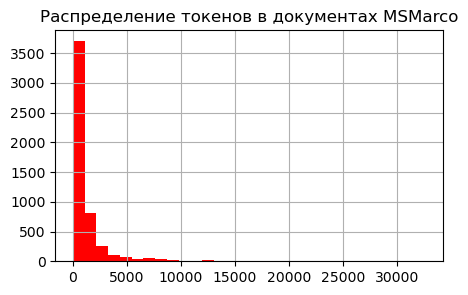

In [32]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.gca()
ms_docs['doc_length'].hist(color='r', bins=30)
plt.title('Распределение токенов в документах MSMarco');

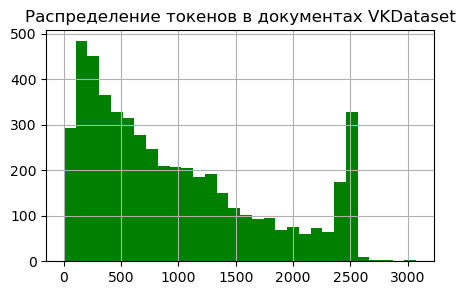

In [33]:
fig = plt.figure(figsize=(5, 3))
ax = fig.gca()
vk_docs['doc_length'].hist(color='g', bins=30)
plt.title('Распределение токенов в документах VKDataset');

Text(0.5, 1.0, 'Распределение токенов в запросах MSMarco')

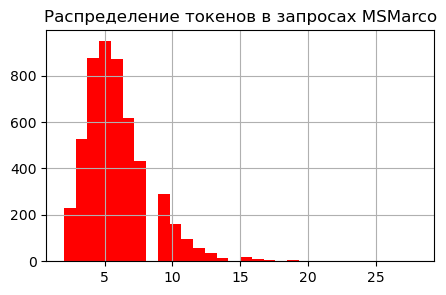

In [35]:
fig = plt.figure(figsize=(5, 3))
ax = fig.gca()
ms_queries['query_length'].hist(color='r', bins=30)
plt.title('Распределение токенов в запросах MSMarco')

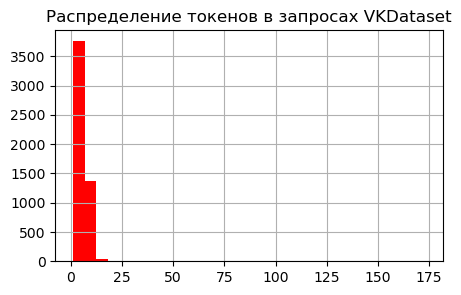

In [36]:
fig = plt.figure(figsize=(5, 3))
ax = fig.gca()
vk_queries['query_length'].hist(color='r', bins=30)
plt.title('Распределение токенов в запросах VKDataset');

### Do we want to look at real documents?
## Считаем статистики по документам ВК и МС Марко

In [20]:
import sys
import os
import csv
import string
csv.field_size_limit(sys.maxsize)

vk_lengths = []
with open(os.path.join('full_dataset/', 'docs.tsv'), 'r') as f:
    csv_reader = csv.reader(f, delimiter='\t')
    for line in csv_reader:
        id, doc_id, data = line
        length = len(str(data).split())
        if length > 0:
            vk_lengths.append(length)

In [77]:
len([vk_lengths[i] for i in range(len(vk_lengths)) if vk_lengths[i] == 2499])

3867

In [21]:
len(vk_lengths), sum(vk_lengths)/len(vk_lengths)

(1304199, 998.2635211344281)

In [23]:
import sys
import csv
import string
csv.field_size_limit(sys.maxsize)
msmarco_length = []

with open('../msmarco_data/docs_400k.tsv', 'r') as f:
    csv_reader = csv.reader(f, delimiter='\t')
    for line in csv_reader:
        id_d, doc_id, data = line
        doc_length = len(data.split())
        msmarco_length.append(doc_length)

In [24]:
len(msmarco_length), sum(msmarco_length)/len(msmarco_length)

(401855, 2095.857821851165)

In [59]:
vk_lengths = sorted(vk_lengths)
msmarco_length = sorted(msmarco_length)

vk_dict = {}
for ln in vk_lengths:
    if ln> 0:
        vk_dict[ln] = vk_dict.get(ln, 0) + 1

ms_dict = {}
for ln in msmarco_length:
    if ln > 0:
        ms_dict[ln] = ms_dict.get(ln, 0) + 1

### Normilize:

In [36]:
for k, v in vk_dict.items():
    v = v / len(vk_lengths)
    vk_dict[k] = v
    
for k, v in ms_dict.items():
    v = v / len(msmarco_length)
    ms_dict[k] = v

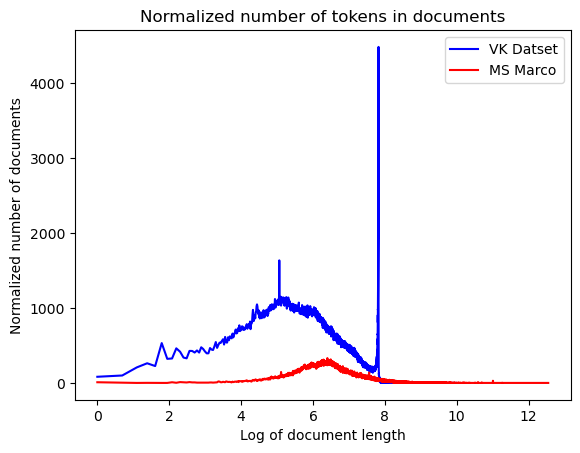

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.plot(list(np.log(list(vk_dict.keys()))), list(vk_dict.values()), color = 'blue', label='VK Datset')
plt.plot(np.log(list(ms_dict.keys())), list(ms_dict.values()), color = 'red', label='MS Marco')
plt.title('Normalized number of tokens in documents')
plt.xlabel('Log of document length')
plt.legend()
plt.ylabel('Normalized number of documents');

### Считаем статистики по запросам в ВК датасете и МС Марко

In [40]:
vk_queries = []
with open(os.path.join('full_dataset/', 'queries.tsv'), 'r') as f:
    csv_reader = csv.reader(f, delimiter='\t')
    for line in csv_reader:
        id, doc_id, data = line
        length = len(str(data).split())
        if length > 0:
            vk_queries.append(length)

In [41]:
len(vk_queries), sum(vk_queries)/len(vk_queries)

(54511, 5.7881528498835095)

In [44]:
ms_queries = []
with open(os.path.join('../msmarco_data/', 'msmarco-doctrain-queries.tsv'), 'r') as f:
    csv_reader = csv.reader(f, delimiter='\t')
    for line in csv_reader:
        id, data = line
        length = len(str(data).split())
        if length > 0:
            ms_queries.append(length)

In [106]:
len(ms_queries), sum(ms_queries)/len(ms_queries)

(367013, 5.951426788696858)

In [49]:
vk_qlengths = sorted(vk_queries)
msmarco_qlength = sorted(ms_queries)

vk_qdict = {}
for ln in vk_qlengths:
    if ln> 0:
        vk_qdict[ln] = vk_qdict.get(ln, 0) + 1
        
ms_qdict = {}
for ln in msmarco_qlength:
    if ln > 0:
        ms_qdict[ln] = ms_qdict.get(ln, 0) + 1

### Normilize queries

In [50]:
for k, v in vk_qdict.items():
    v = v / len(vk_queries)
    vk_qdict[k] = v
    
for k, v in ms_qdict.items():
    v = v / len(ms_queries)
    ms_qdict[k] = v

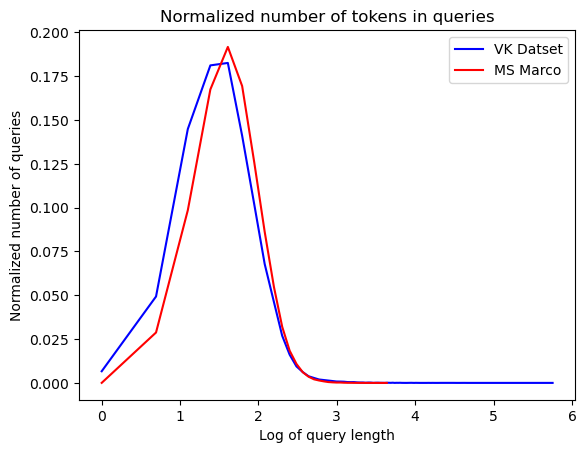

In [53]:
import numpy as np
import pandas as pd

plt.plot(np.log(list(vk_qdict.keys())), list(vk_qdict.values()), color = 'blue', label='VK Datset')
plt.plot(np.log(list(ms_qdict.keys())), list(ms_qdict.values()), color = 'red', label='MS Marco')
plt.title('Normalized number of tokens in queries')
plt.xlabel('Log of query length')
plt.legend()
plt.ylabel('Normalized number of queries');

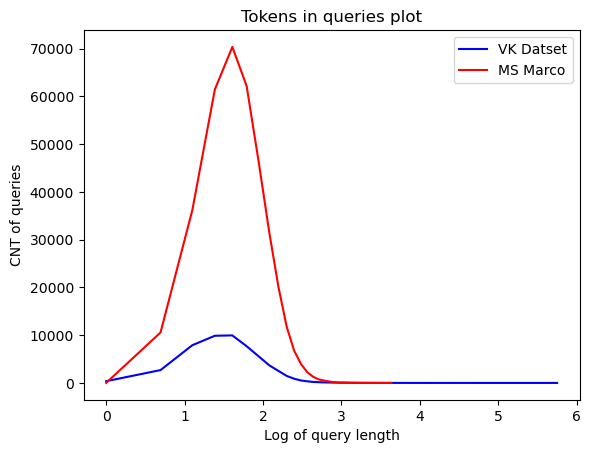

In [110]:
import numpy as np
import pandas as pd

plt.plot(np.log(list(vk_qdict.keys())), list(vk_qdict.values()), color = 'blue', label='VK Datset')
plt.plot(np.log(list(ms_qdict.keys())), list(ms_qdict.values()), color = 'red', label='MS Marco')
plt.title('Tokens in queries plot')
plt.xlabel('Log of query length')
plt.legend()
plt.ylabel('CNT of queries');

### T5 model 

In [ ]:
import torch
from tqdm import tqdm
from config.utils import DB_PATH
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from query_generator import QueryGenerator
from iterator import DBIterator

DEVICE = "cpu"


class NLPModel():
    def __init__(self, model, tokenizer, min_length, max_length, num_first_tokens):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.min_length = min_length
        self.num_first_tokens = num_first_tokens

    def __call__(self, list_docs):
        splitted_tokens = [txt.split()[:self.num_first_tokens] for txt in list_docs]
        texts = [' '.join(tokens) for tokens in splitted_tokens]
        texts = [WHITESPACE_HANDLER(text) for text in texts]
        #texts = ['summarize: ' + txt for txt in texts]
        token_batch = self.tokenizer(texts, truncation=True, padding="max_length",
                                     return_tensors="pt").to(DEVICE)
        summ = self.model.generate(**token_batch, min_length=self.min_length,
                                     max_length=self.max_length)
        decoded_summ = self.tokenizer.batch_decode(summ, max_length=self.max_length,
                                                   num_beams=4,
                                                   skip_special_tokens=True)
        return decoded_summ


if __name__ == '__main__':
    model_list_names = ["csebuetnlp/mT5_multilingual_XLSum", ]
    model_name =  'cointegrated/rut5-base-absum' #"csebuetnlp/mT5_multilingual_XLSum" #"t5-small"
    EXPERIMENT_NAME = 'mT5_multilingual_XLSum'
    WHITESPACE_HANDLER = lambda k: re.sub('\s+', ' ', re.sub('\n+', ' ', k.strip()))

    BS = 15
    #model = T5ForConditionalGeneration.from_pretrained(model_name).to(DEVICE)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name) #T5Tokenizer.from_pretrained(model_name)
    nlp_model = NLPModel(model, tokenizer, 0, 100, 100)
    experiment = QueryGenerator(nlp_model, EXPERIMENT_NAME, db_path=DB_PATH)
    db_iterator = DBIterator('DOCS', batch_size=BS, db_path=DB_PATH)
    for batch_data in tqdm(db_iterator):
        experiment.generate_query(batch_data)


### Full MSMarco

In [6]:
import sys
import csv
import string
csv.field_size_limit(sys.maxsize)
docs_length = []

with open('docs_400k.tsv', 'r') as f:
    csv_reader = csv.reader(f, delimiter='\t')
    for line in csv_reader:
        id_d, doc_id, data = line
        doc_length = len(data.split())
        docs_length.append(doc_length)

In [8]:
len(docs_length), sum(docs_length)/len(docs_length)

(401855, 2095.857821851165)